In [ ]:
!pip install llama-index-multi-modal-llms-ollama
!pip install llama-index-readers-file
!pip install unstructured
!pip install llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-qdrant
!pip install llama-index-embeddings-clip

In [ ]:
!pip install llama-index-llms-ollama==0.4.1
!pip install llama-index-multi-modal-llms-ollama==0.4.0
!pip install ollama==0.3.3

In [18]:
from llama_index.multi_modal_llms.ollama import OllamaMultiModal

In [19]:
mm_model = OllamaMultiModal(model="llava:7b")

In [20]:
from pathlib import Path
from llama_index.core import SimpleDirectoryReader
from PIL import Image
import matplotlib.pyplot as plt

input_image_path = Path("restaurant_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

# load as image documents
image_documents = SimpleDirectoryReader("seed_data").load_data()

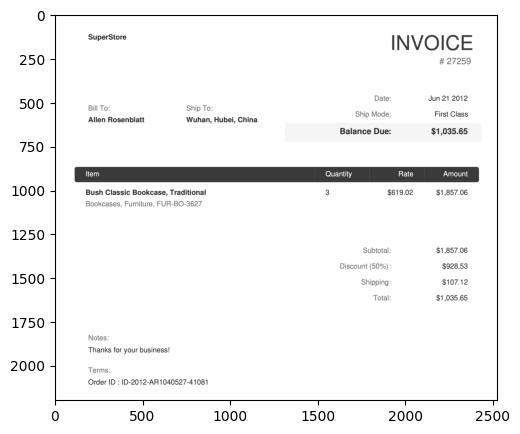

In [21]:
imageUrl = "seed_data/sample.png"
image = Image.open(imageUrl).convert("RGB")
plt.figure(figsize=(16, 5))
plt.imshow(image)

In [22]:
from pydantic import BaseModel


class Extractor(BaseModel):
    """Data model for an restaurant."""

    Bill_TO: float
    SHIP_TO: float
    Date: str
    Less_Payment: float
    Items:str
    Order_ID: str 

In [23]:
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
{query_str}

Return the answer as a Pydantic object. The Pydantic schema is given below:

"""
mm_program = MultiModalLLMCompletionProgram.from_defaults(
    output_parser=PydanticOutputParser(Extractor),
    image_documents=image_documents,
    prompt_template_str=prompt_template_str,
    multi_modal_llm=mm_model,
    verbose=True,
)

In [24]:
response = mm_program(query_str="make a correct pydantic for the image which covers maximum datapoints")

> Raw output:  ```json
{
  "Bill_TO": 12345,
  "SHIP_TO": 67890,
  "Date": "Jun 3, 2023",
  "Less_Payment": "$0.00",
  "Items": "Bookcase",
  "Order_ID": "12345"
}
```

This JSON object represents the information visible in the image and follows the Pydantic schema provided. The `Bill_TO`, `SHIP_TO`, `Date`, `Less_Payment`, `Items`, and `Order_ID` fields are all present, each with a value that matches the data displayed in the image. 


ValidationError: 1 validation error for Extractor
Less_Payment
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='$0.00', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/float_parsing

### 1.0 Entity Extractor

In [1]:
from llama_index.extractors.entity import EntityExtractor
from llama_index.core.node_parser import SentenceSplitter

entity_extractor = EntityExtractor(
    prediction_threshold=0.5,
    label_entities=False,  # include the entity label in the metadata (can be erroneous)
    device="mps",  # set to "cuda" if you have a GPU
)

node_parser = SentenceSplitter()

transformations = [node_parser, entity_extractor]

/Users/kartikey/miniforge3/envs/dhobify/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kartikey/miniforge3/envs/dhobify/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in EntityExtractor has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [5]:
image_documents = SimpleDirectoryReader("seed_data").load_data()

In [7]:
import nest_asyncio

nest_asyncio.apply()

In [11]:

from llama_index.core.ingestion import IngestionPipeline

import random


pipeline = IngestionPipeline(transformations=transformations)

nodes = pipeline.run(documents=image_documents)

Extracting entities: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


In [14]:
for i in nodes:
    print(i.metadata)

{'file_path': '/Users/kartikey/Desktop/spottable/seed_data/sample.png', 'file_name': 'sample.png', 'file_type': 'image/png', 'file_size': 286860, 'creation_date': '2024-12-17', 'last_modified_date': '2024-12-17'}
